# Context
This notebook drives the training process for different models.

In [1]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [2]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [3]:
num_classes = 10
scores_path = os.path.join(sup.SCORES_ROOT, "specified", sup.TRAIN_BERT_CODE, f"PREPanalysis{num_classes}.csv")

top_barrier=2

## Helper functions

In [4]:
import math

def significance(row, score_col):
  C = int(row["num_classes"])
  score = row[score_col]

  k = 2 if score_col == 'top2accuracy' else 1
  if C == k:
    return 0
  
  # Chance the true class appears in a random top-k set:
  # Choose (k - 1) other classes from the remaining (C - 1), then divide by all
  # possible top-k sets
  # chance_score = math.comb(C - 1, k - 1)  /  math.comb(C, k)
  #       "      = ((C-1)! / ((C-1-(k-1))! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / ((C-k)! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / (k-1)!)  /  (C! / k!)
  #       "      = ((C-1)! / C!)  /  ((k-1)! / k!)
  #       "      = (k! / (k-1)!) / (C! / (C-1)!)
  #       "      = k / C
  # So:
  chance_score = k / C

  if score_col == 'accuracy' or score_col == 'top2accuracy':
    std = math.sqrt(chance_score * (1 - chance_score) / 100 * C)
  elif score_col == 'macro_recall':
    std = math.sqrt((1 - chance_score) / (100 * C**2))
  elif score_col == 'macro_precision':
    std = math.sqrt((C - 1) / (100 * C**2))

  z = (score - chance_score)/std

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
def visualize(df: pd.DataFrame, group_cols, top, filter_cols=None, filter_values=None):
  """
  Optionally filters df by filter_cols == filter_values, groups by group_cols,
  selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
  """
  filter_desc = ""

  # Optional filtering
  if filter_cols and filter_values:
    for col, val in zip(filter_cols, filter_values):
      df = df[df[col] == val]
    filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

  if df.empty:
    print("Warning: DataFrame is empty after filtering.")
    return

  # Group + mean of top k
  def top_k_mean(g):
    top_k = g.sort_values('accuracy', ascending=False).head(top)
    if top_k.empty:
      return float('nan')  # or 0.0
    return top_k['accuracy'].mean()

  mean_accuracies = (
      df.groupby(group_cols)
        .apply(top_k_mean)
        .to_frame('mean_accuracy')
        .reset_index()
  )

  if mean_accuracies.empty:
    print("Warning: No data to plot after grouping.")
    return

  # Create labels
  mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

  # Plotting
  colors = sns.color_palette("muted", len(mean_accuracies))
  plt.figure(figsize=(10, 6))
  plt.bar(mean_accuracies['label'], mean_accuracies['mean_accuracy'], color=colors)

  plt.ylabel(f"Mean Accuracy (Top {top})")
  plt.title(f"Top {top} Mean Accuracies per {' + '.join(group_cols)}{filter_desc}")
  plt.xticks(rotation=45, ha='right')

  # Add y-limit padding
  min_val = mean_accuracies['mean_accuracy'].min()
  max_val = mean_accuracies['mean_accuracy'].max()
  padding = (max_val - min_val) * 0.3 if max_val > min_val else 0.1
  plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

  # Add value labels
  for i, val in enumerate(mean_accuracies['mean_accuracy']):
    plt.text(i, val + padding * 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()



## Data

In [7]:
bert_scores_df = pd.read_csv(scores_path)
bert_scores_df.sort_values(by="top2accuracy", ascending=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/diego/Desktop/iteso/TOG/scores/specified/BERT/PREPanalysis10.csv'

In [ ]:
for metric_name in ['accuracy', 'top2accuracy', 'macro_precision', 'macro_recall']:
  bert_scores_df[f'{metric_name}_z'] = bert_scores_df.apply(lambda x: significance(x, metric_name), axis=1)

bert_scores_df['harmonic_z'] = bert_scores_df.apply(harmonic_z, axis=1)

bert_scores_df

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z,top2accuracy_z,macro_precision_z,macro_recall_z,harmonic_z
0,Spf,False,2,easy,0.681641,1,0.654705,0.785012,0.688565,2.568786,0,5.700242,5.333420,5.510734
1,Spf,False,2,average,0.693359,1,0.669711,0.790572,0.700015,2.734515,0,5.811431,5.657286,5.733323
2,Spf,False,2,hard,0.863281,1,0.863072,0.868270,0.864672,5.137573,0,7.365402,10.314475,8.593980
3,Spf,True,2,easy,0.714844,1,0.703999,0.763012,0.719725,3.038349,0,5.260234,6.214767,5.697800
4,Spf,True,2,average,0.771484,1,0.770285,0.781392,0.773603,3.839369,0,5.627836,7.738663,6.516580
5,Spf,True,2,hard,0.664062,1,0.636069,0.756601,0.670931,2.320194,0,5.132013,4.834667,4.978905
6,Spv,False,2,easy,0.511628,1,0.376812,0.750000,0.522727,0.164443,0,5.000000,0.642824,1.139189
7,Spv,False,2,average,0.674419,1,0.641667,0.800000,0.681818,2.466652,0,6.000000,5.142595,5.538309
8,Spv,False,2,hard,0.744186,1,0.741953,0.748889,0.742424,3.453312,0,4.977778,6.856793,5.768117
9,Spv,True,2,easy,0.720930,1,0.701389,0.818182,0.727273,3.124425,0,6.363636,6.428243,6.395777


### Inital number-of-classes-agnostic analysis

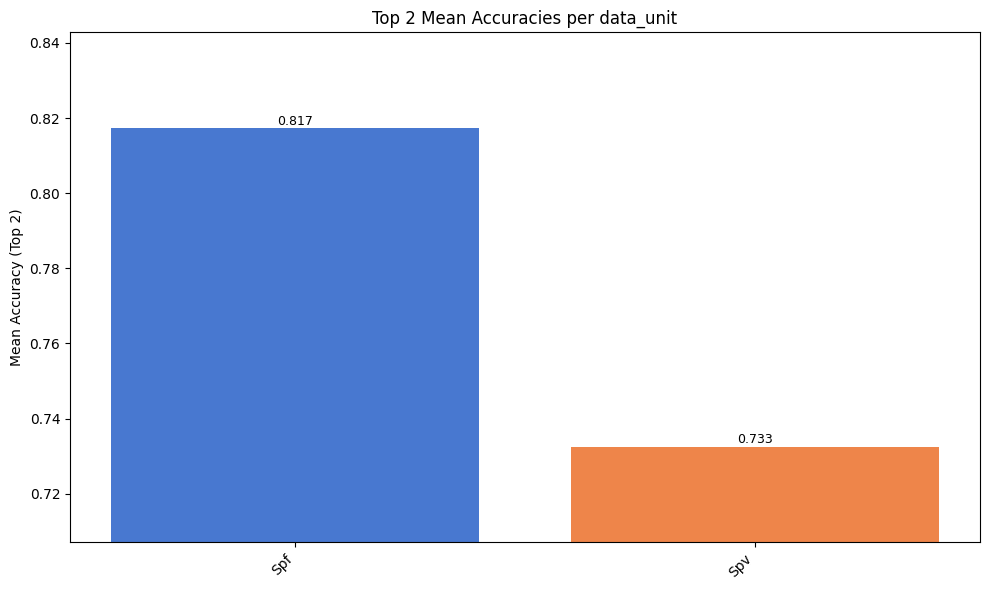

In [ ]:
visualize(bert_scores_df, group_cols=['data_unit'], top=top_barrier)

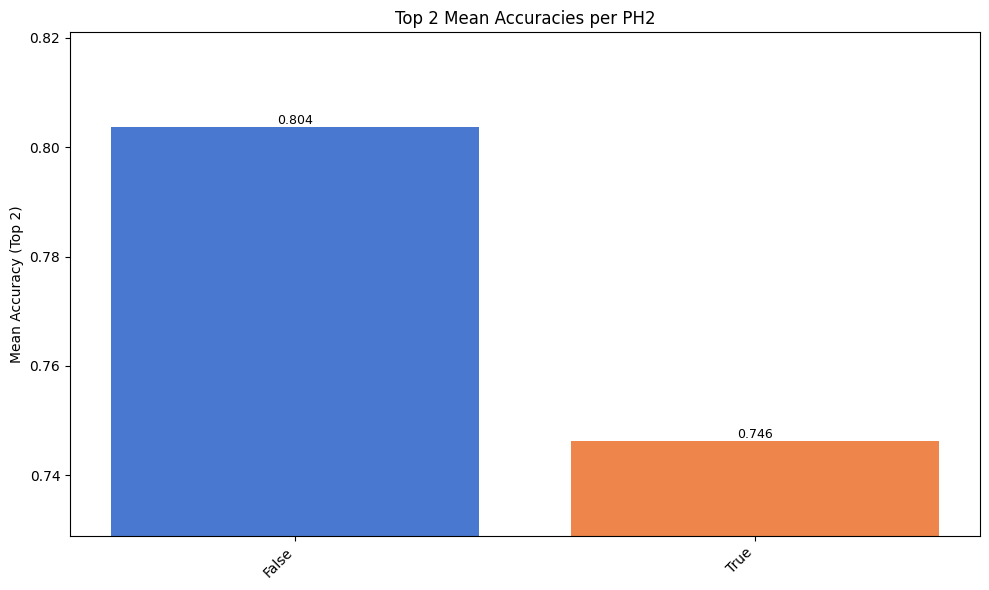

In [ ]:
visualize(bert_scores_df, group_cols=['PH2'], top=top_barrier)

In [ ]:
visualize(bert_scores_df, group_cols=['difficulty'], top=top_barrier, sortby='accuracy')

TypeError: visualize() got an unexpected keyword argument 'sortby'

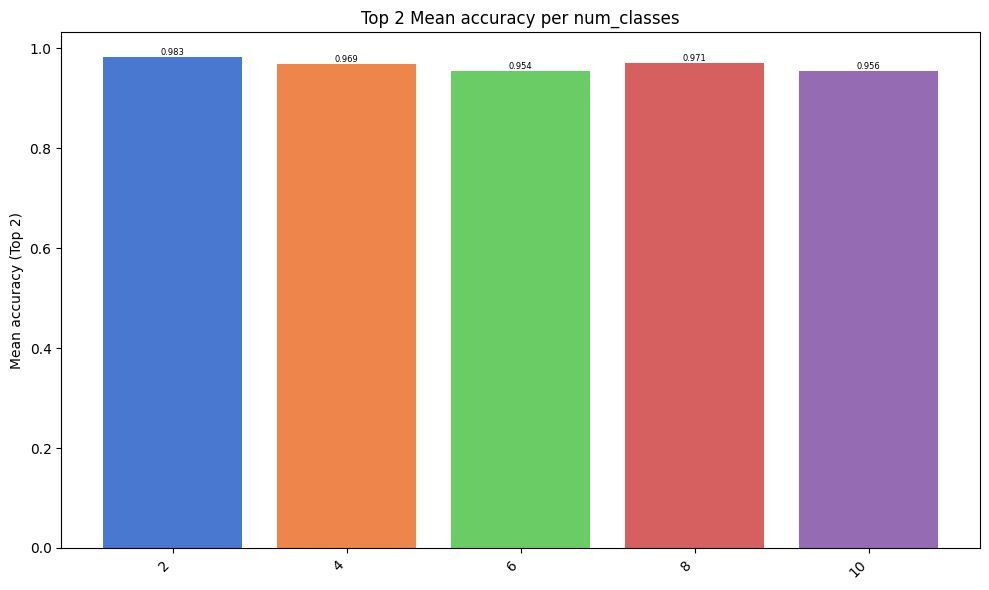

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier)

### Intial analysis compensanting for number of classes

#### data_unit

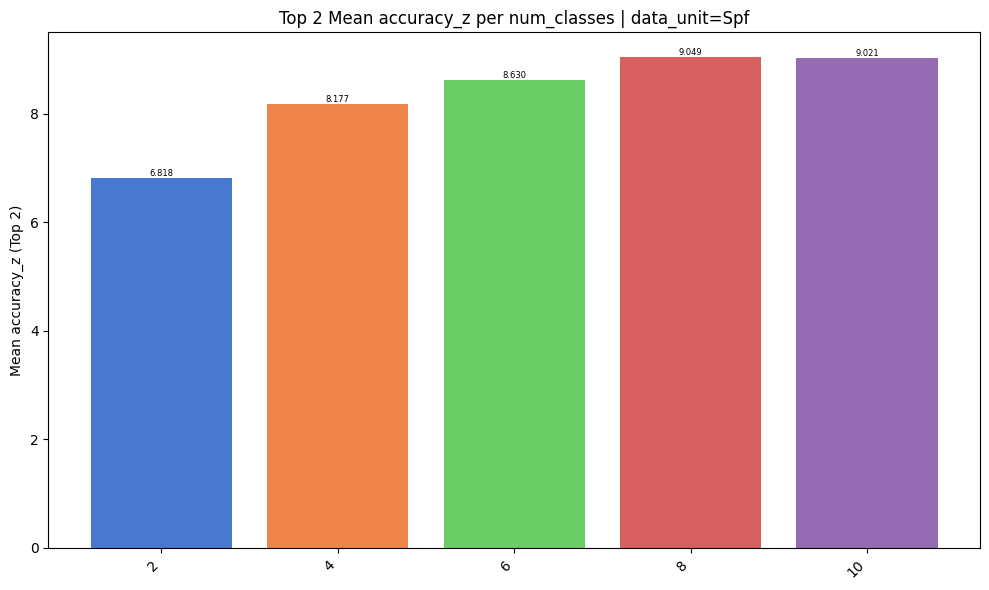

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='accuracy_z')

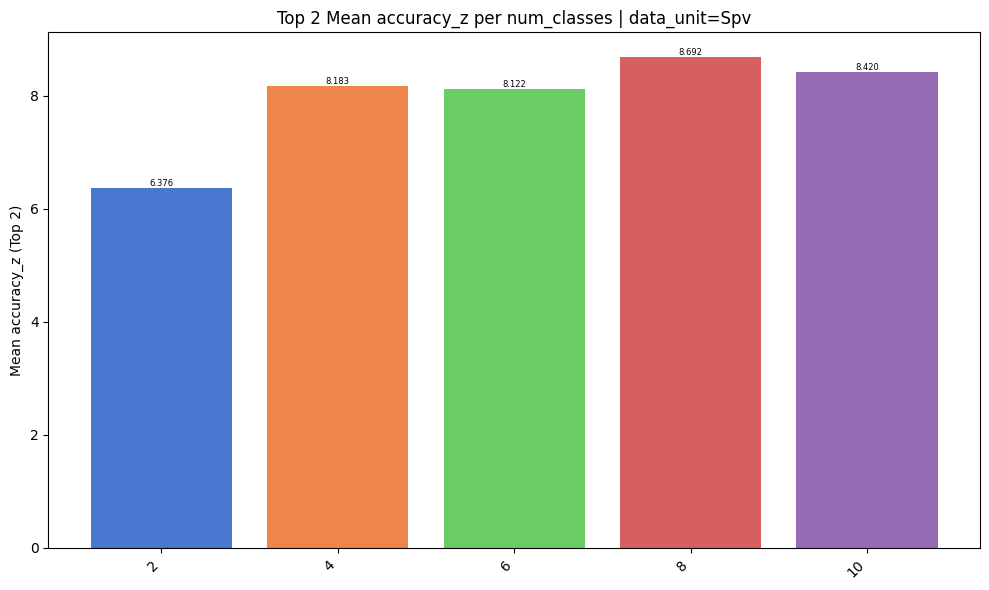

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='accuracy_z')

#### PH2

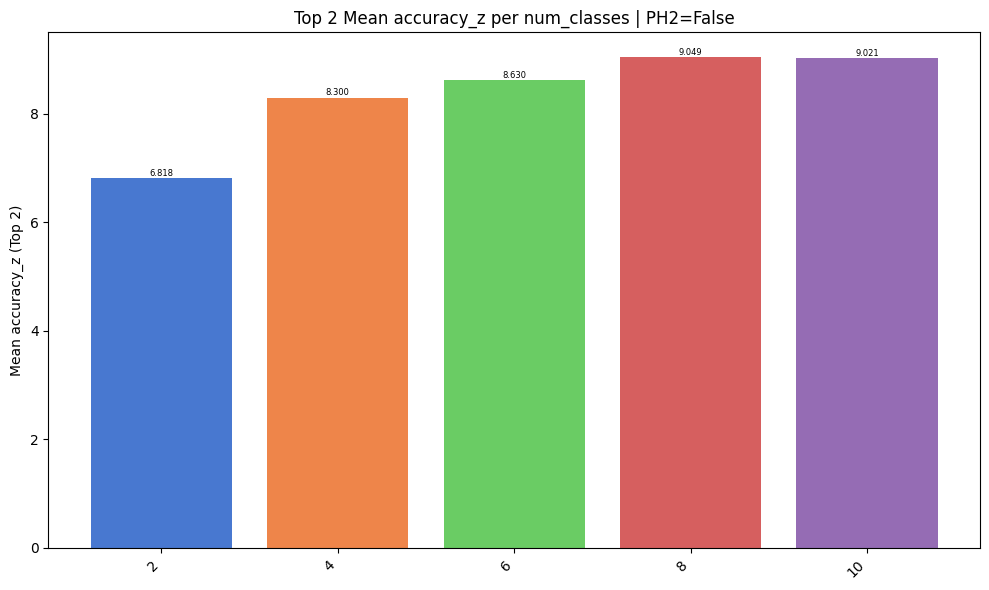

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='accuracy_z')

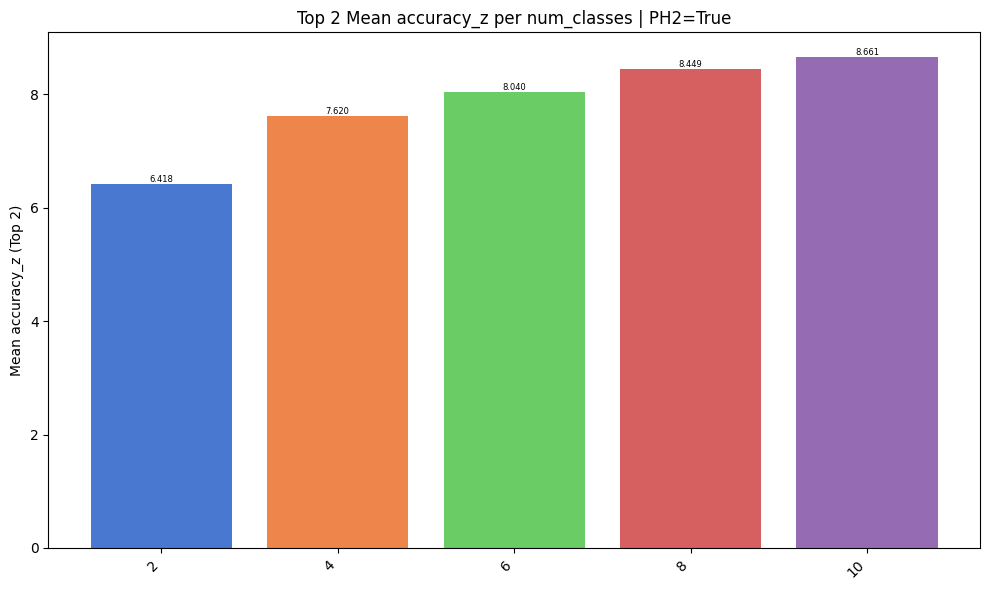

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='accuracy_z')

#### difficulty

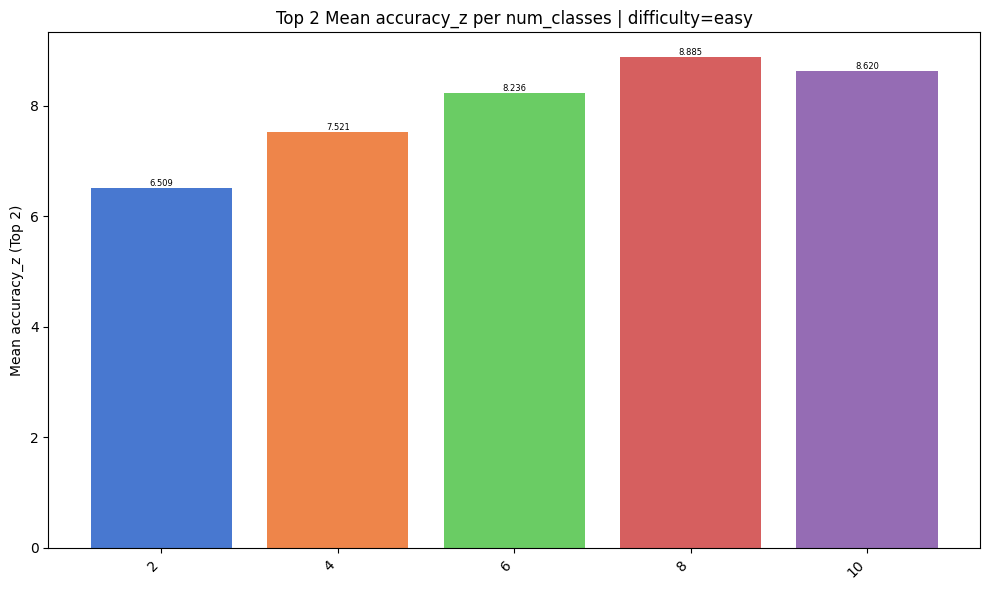

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='accuracy_z')

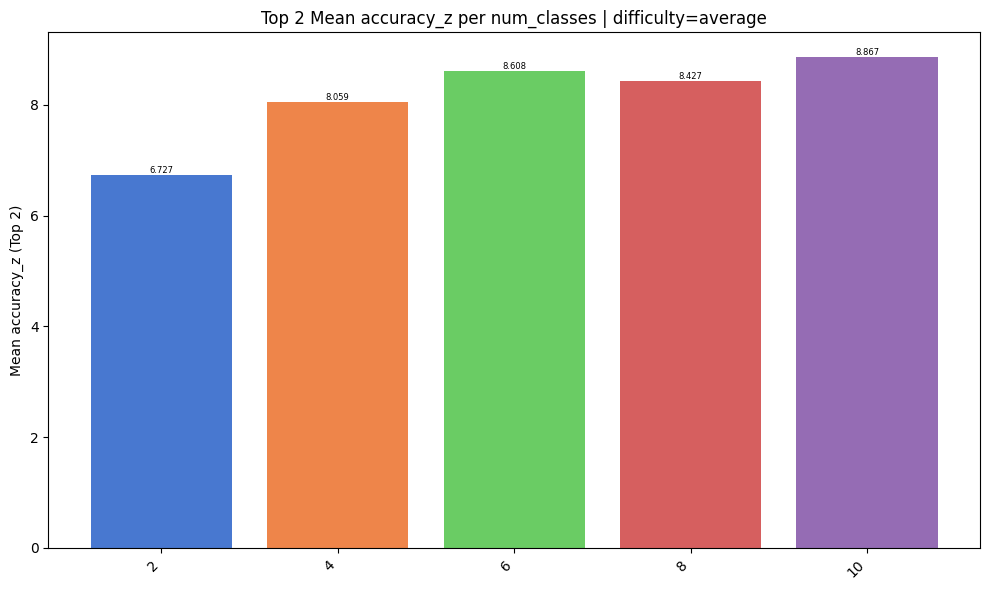

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='accuracy_z')

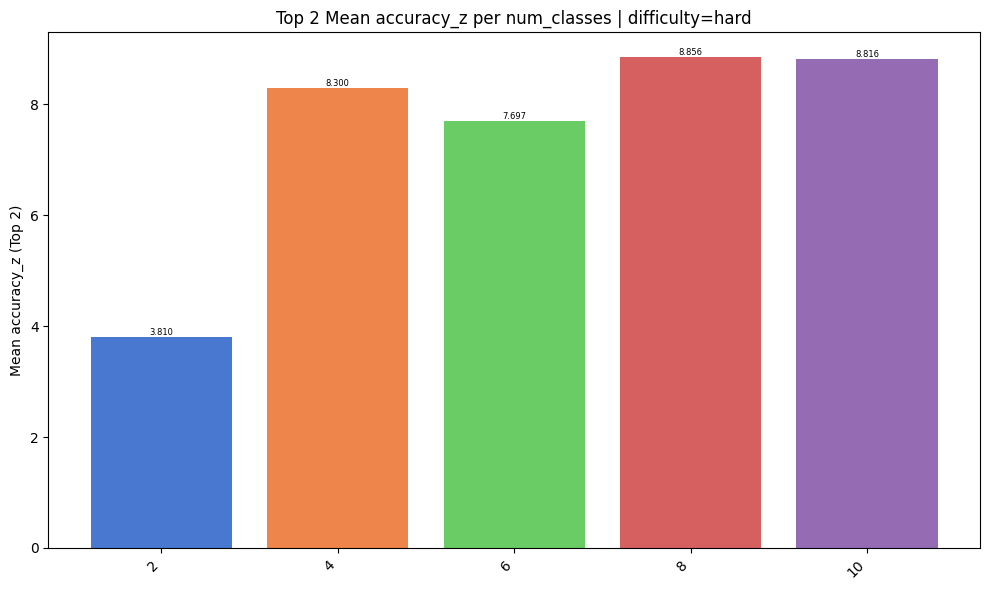

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='accuracy_z')

### Same but with harmonization of significance or recall and precision

#### data_unit

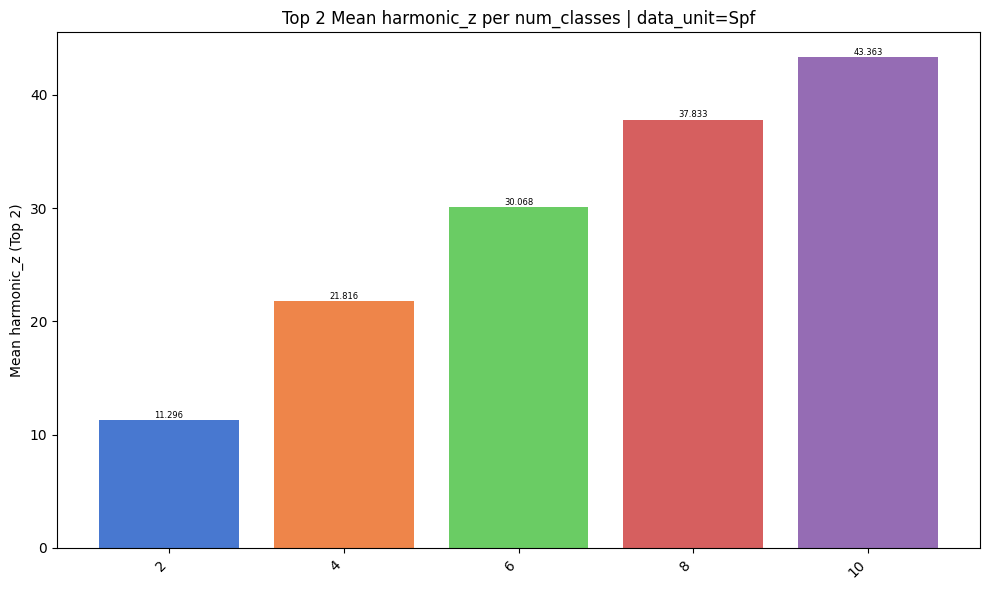

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='harmonic_z')

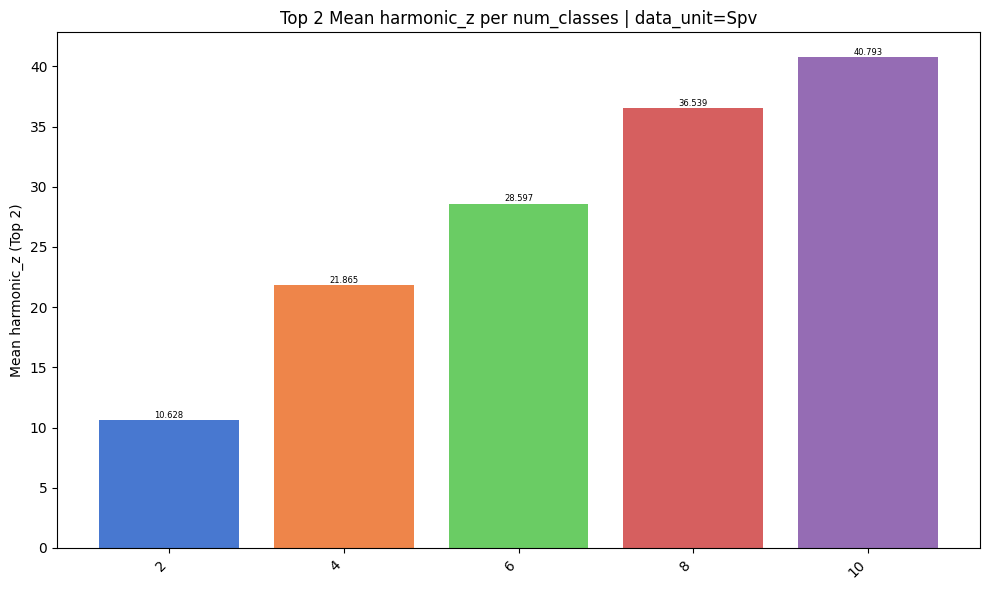

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='harmonic_z')

#### PH2

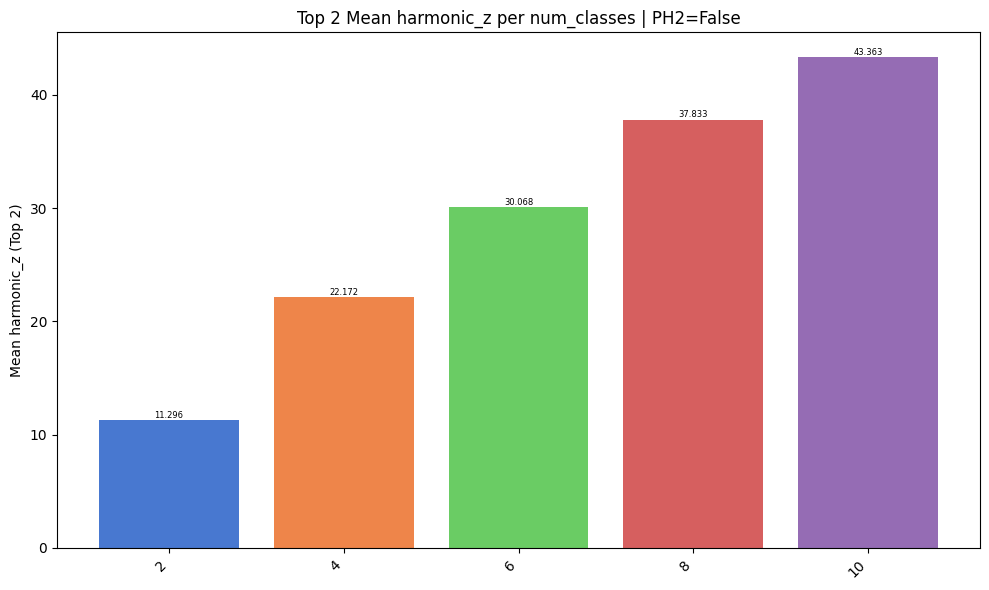

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='harmonic_z')

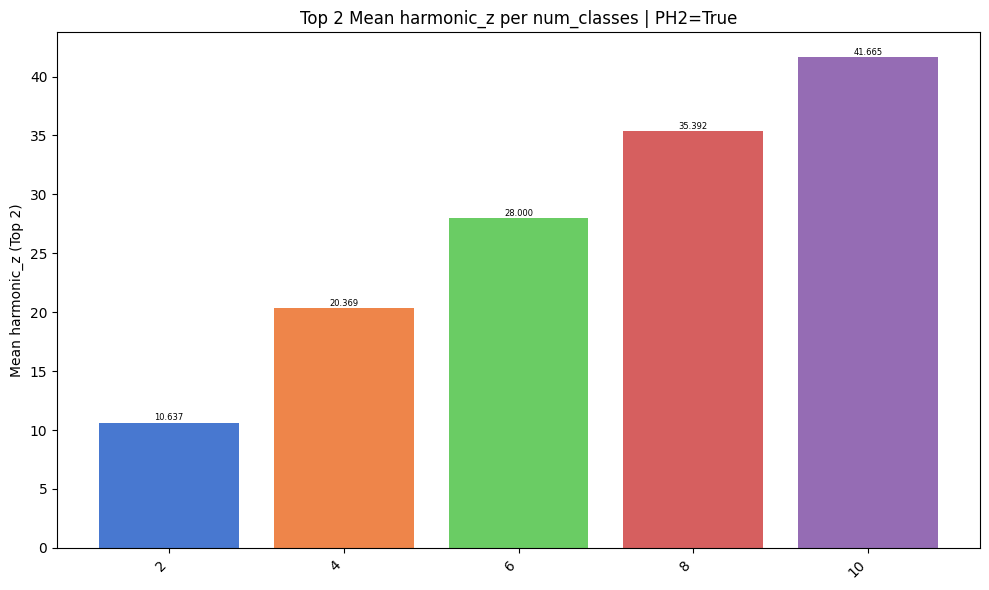

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='harmonic_z')

#### difficulty

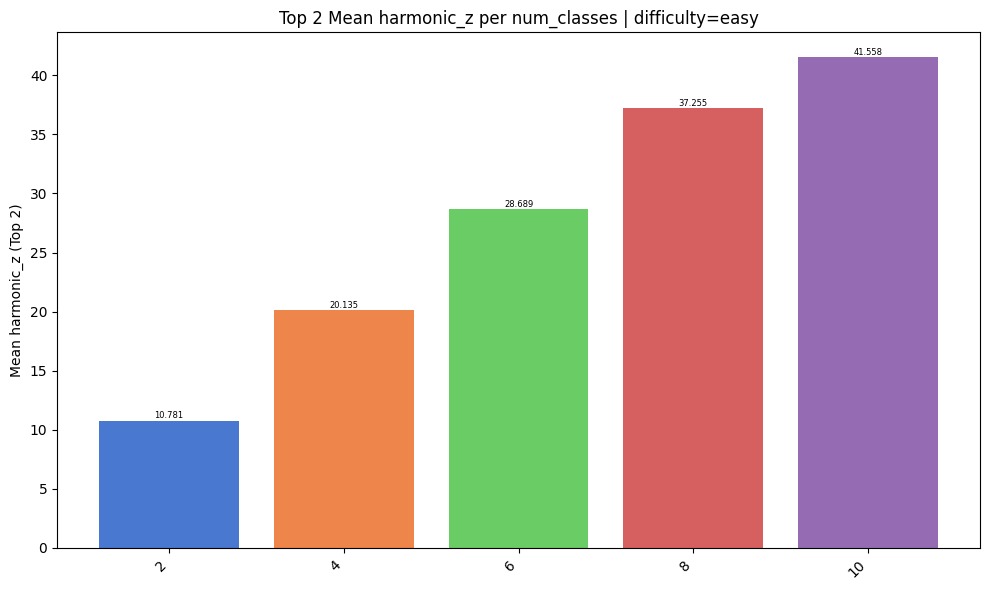

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='harmonic_z')

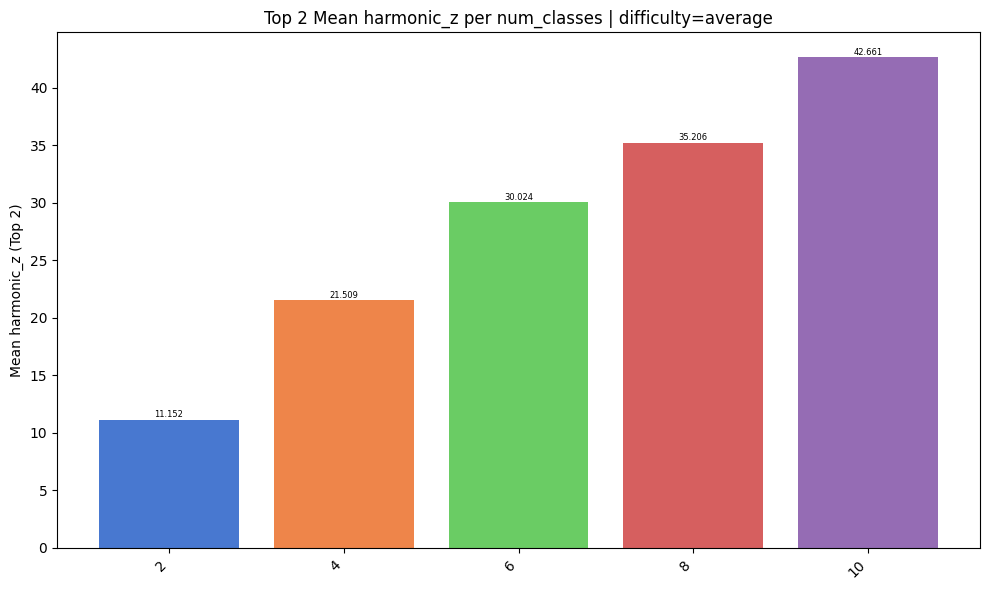

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='harmonic_z')

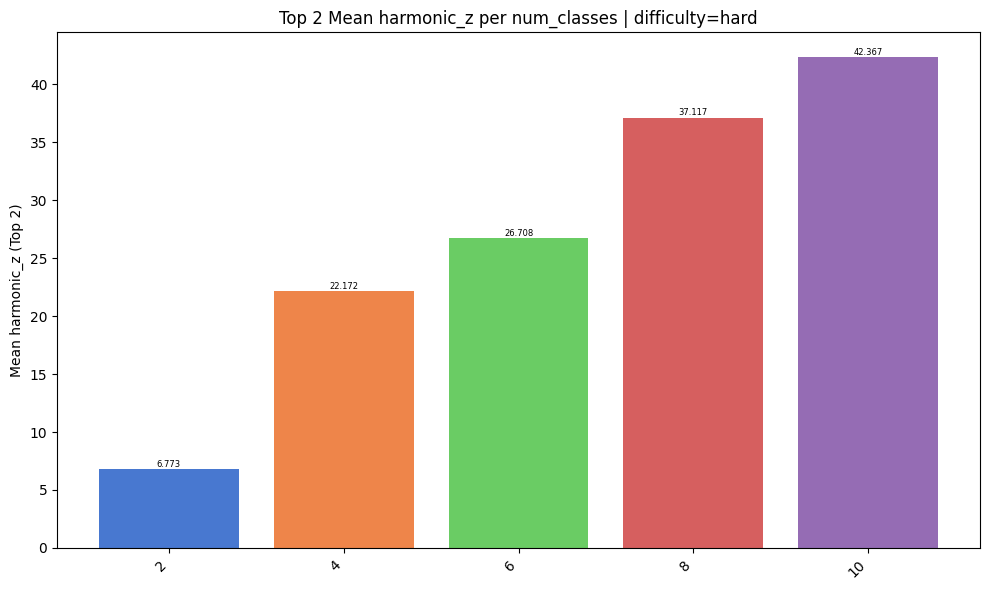

In [ ]:
visualize(bert_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='harmonic_z')